# Differentiation using Trispectral

In this notebook, we show how to perform differentiation using Trispectral. The differentiation routines currently include:

- `DifferentialMatrix`: compute partial derivatives.
- `gradient_operator`: compute the gradient of a scalar field.
- `divergence_operator`: compute the divergence of a vector field.
- `scalar_laplacian_operator`: compute the Laplacian of a scalar field.
- `vector_laplacian_operator`: compute the Laplacian of a vector field.
- `directional_derivative_operator`: compute the directional derivative for two vector fields.
- `curl_operator`: compute the curl of a 3D vector field.

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import trispectral as ts

In [2]:
cwd = os.path.abspath("")

plt.style.use(os.path.join(cwd, "../misc/mpl_styles/main.mplstyle"))

## Non-periodic domains

In the case of Cartesian geometry with $n$ non-periodic directions, we use the Chehyshev collocation method to perform differentiation. Let us consider the following 2D Chebyshev-Chebyshev grid.

In [32]:
nx = ny = 41

grid = ts.Grid.from_bounds(
    [-2., 2., nx], [-2., 2., ny], discs=["chebyshev"] * 2
)

x, y = grid

For this grid, we then create the scalar function $f\left( x,y \right) = xe^{-\left( x^2 + y^2 \right)}$.

In [33]:
f = x * np.exp(-x**2 - y**2)

### Partial derivatives

To compute $x$ and $y$ partial derivatives of $f$, we use `DifferentialMatrix`.

In [34]:
d1x = ts.DifferentialMatrix(grid, axis=0, order=1) @ f
d2y = ts.DifferentialMatrix(grid, axis=1, order=2) @ f

Here, `d1x` and `d2y` represent the first derivative of $f$ with respect to $x$ and the second derivative of $f$ with respect to $y$, respectively. Note, that $x$ and $y$ correspond to axes 0 and 1 of the grid.

The mixed derivative $\partial^2 f/\partial x\partial y$ can be computed as follows: 

In [35]:
d2xy = ts.DifferentialMatrix(grid, axis=1, order=1) @ d1x

We then check that the numerical values coincide with the analytical values.

In [38]:
assert np.allclose(d1x, np.exp(-x**2 - y**2) - 2 * x * f)
assert np.allclose(d2y, -2 * f + 4 * y**2 * f)
assert np.allclose(d2xy, -2 * y * np.exp(-x**2 - y**2) + 4 * x * y * f)

### Gradient

The gradient of $f$ can be computed as follows:

In [5]:
g = ts.gradient_operator(grid) @ f

This yields a vector grid field, i.e., the size of `g` is `2 * nx * ny`. We can extract its $x$ and $y$ components as follows:

In [6]:
gx, gy = g[: nx * ny], g[nx * ny :]

To be sure that our computations are correct, we check if `g` coincides with the analytical values.

In [7]:
assert np.allclose(gx - np.exp(-x**2 - y**2) + 2 * x * f, 0)
assert np.allclose(gy + 2 * y * f, 0)

The field lines of the vector $\nabla f$ are shown below (note that `matplotlib` needs meshgrid representations of the grid data, so we reshape all the arrays).

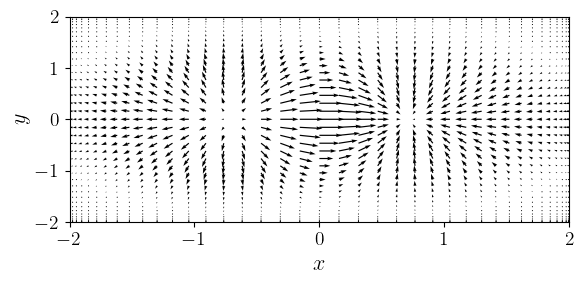

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

ax.quiver(
    x.reshape(nx, ny, order="F"),
    y.reshape(nx, ny, order="F"),
    gx.reshape(nx, ny, order="F"),
    gy.reshape(nx, ny, order="F"),
    scale=20,
)

ax.set_xticks(np.arange(-2, 3, 1))
ax.set_yticks(np.arange(-2, 3, 1));

# plt.savefig("ex_1.pdf");

### Divergence

The divergence of $\nabla f$ can be evaluated as follows:

In [9]:
d = ts.divergence_operator(grid) @ g

### Laplacian

This is analogous to computing the Laplacian of $f$.

In [10]:
sl = ts.scalar_laplacian_operator(grid) @ f

We then check that `sl` and `d` coincide and that `sl` coincides with the exact value $\nabla^2 f$.

In [11]:
assert np.allclose(d, sl)
assert np.allclose(sl + 8 * f - 4 * (x**2 + y**2) * f, 0)

Graphically, $\nabla^2 f$ can be represented as follows:

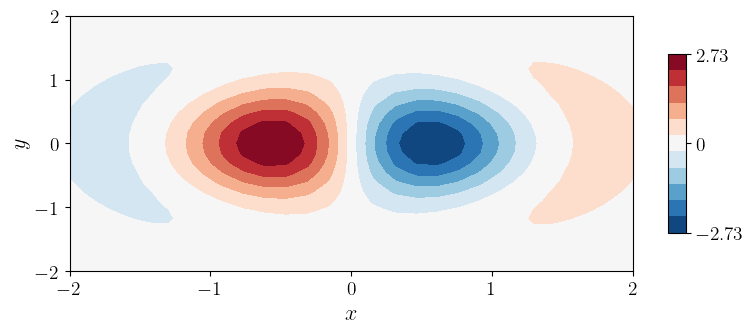

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), tight_layout=True)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

c = ax.contourf(
    x.reshape(nx, ny, order="F"),
    y.reshape(nx, ny, order="F"),
    sl.reshape(nx, ny, order="F"),
    levels=np.linspace(np.min(sl), np.max(sl), 12),
    cmap=plt.get_cmap("RdBu_r"),
)

cbar = plt.colorbar(
    c,
    ax=ax,
    ticks=[np.min(sl), 0, np.max(sl)],
    location="right",
    shrink=0.7,
    aspect=10,
)
cbar.ax.set_yticklabels([f"${np.min(sl): .2f}$", 0, f"${np.max(sl): .2f}$"])


ax.set_xticks(np.arange(-2, 3, 1))
ax.set_yticks(np.arange(-2, 3, 1));

# plt.savefig("ex_2.pdf");

To compute the Laplacian of a vector field, we can use the `vector_laplacian_operator` function. We evaluate the Laplacian of $\nabla f$ as follows:

In [13]:
vl = ts.vector_laplacian_operator(grid) @ g
vlx, vly = vl[: nx * ny], vl[nx * ny :]

In [14]:
assert np.allclose(vlx, ts.scalar_laplacian_operator(grid) @ gx)
assert np.allclose(vly, ts.scalar_laplacian_operator(grid) @ gy)

### Directional derivative

Now, consider the following two vector functions:

$\boldsymbol{a}\left( x,y \right) = \left( x + y \right)\boldsymbol{1}_x + \left( x - y \right)\boldsymbol{1}_y$, 

and

$\boldsymbol{b}\left( x,y \right) = \cos{\left( x^2 + y^2 \right)}\boldsymbol{1}_x + \sin{\left( x^2 + y^2 \right)}\boldsymbol{1}_y$.

In [15]:
a = np.concatenate([x + y, x - y])
b = np.concatenate([np.cos(x**2 + y**2), np.sin(x**2 + y**2)])

The directional derivative $\boldsymbol{a}\cdot\nabla \boldsymbol{b}$ can be computed as follows:

In [16]:
ca = ts.directional_derivative_operator(grid, a=a) @ b

Or, equivalently, as follows:

In [17]:
cb = ts.directional_derivative_operator(grid, b=b) @ a

In [18]:
assert np.allclose(ca, cb)

### Curl

The curl operator is only defined for 3D domains. In this example, consider the following vector 3D function:

$\boldsymbol{u}\left( x, y, z \right) = -\sin{\left( x + y \right)}\boldsymbol{1}_x + \left[ -\sin{\left( x + y \right)} + \cos{\left( z - y \right)} \right]\boldsymbol{1}_y - \cos{\left( z - y \right)}\boldsymbol{1}_z$.

First, we introduce the 3D Chebyshev grid.

In [19]:
nx = ny = nz = 21

grid = ts.Grid.from_bounds(
    [-np.pi / 2, np.pi / 2, nx],
    [-np.pi / 2, np.pi / 2, ny],
    [-np.pi / 2, np.pi / 2, nz],
    discs=3 * ["chebyshev"],
)
x, y, z = grid

Then, we compute the curl of $\boldsymbol{u}$ as follows:

In [20]:
u = np.concatenate(
    [
        -np.sin(x + y),
        -np.sin(x + y) + np.cos(z - y),
        -np.cos(z - y),
    ]
)

In [21]:
c = ts.curl_operator(grid) @ u

We then verify that the resulting field is 0 everywhere (as the curl of the gradient is always zero).

In [22]:
assert np.allclose(c, 0)

## Domains with periodic directions

In the case of a domain with one or multiple periodic directions, the differentiation is performed in the exact same manner. Consider the following 2D periodic grid (note the current limitations on the limits of periodic domains in Trispectral: they must range from $-\pi$ to $\pi - \Delta x$):

In [23]:
nx = ny = 32

grid = ts.Grid.from_bounds(
    [-np.pi, np.pi - 2.0 * np.pi / nx, nx],
    [-np.pi, np.pi - 2.0 * np.pi / ny, ny],
    discs=["periodic"] * 2,
)
x, y = grid

We then create a periodic scalar function and compute its gradient.

In [24]:
f = np.sin(3 * x) * np.cos(y)

In [25]:
g = ts.gradient_operator(grid) @ f
gx, gy = g[: nx * ny], g[nx * ny :]

In [26]:
assert np.allclose(gx - 3 * np.cos(3 * x) * np.cos(y), 0)
assert np.allclose(gy + np.sin(3 * x) * np.sin(y), 0)

Similarly, consider the case of one periodic and one non-periodic directions:

In [27]:
nx = 41
ny = 28

grid = ts.Grid.from_bounds(
    [0., 2., nx],
    [-np.pi, np.pi - 2.0 * np.pi / ny, ny],
    discs=["chebyshev", "periodic"],
)
x, y = grid

We introduce the following vector function and compute its divergence:

In [28]:
u = np.concatenate(
    [x * np.sinh(x) * np.sin(y), np.cosh(x) * np.cos(y)]
)

In [29]:
d = ts.divergence_operator(grid) @ u

In [30]:
assert np.allclose(
    d
    - np.sinh(x) * np.sin(y)
    - x * np.cosh(x) * np.sin(y)
    + np.cosh(x) * np.sin(y),
    0,
)